# This EDA is Work in Progress !

# miRNA Biomarker for Lung Cancer Diagnostics

***- Selecting a test panel for patient classification -***

Author: Dr. Patrick Neubert <br>
eMail: patrick.neubert@t-online.de <br>
LinkedIn: https://www.linkedin.com/in/dr-patrick-neubert-91910b111/

## Abstract

Lung cancer is the most prevalent cancer disease worldwide. The current standard diagnostics for lung cancer are X-ray imaging, sputum cytology and tissue samples (biopsy), which are inapplicable for early detection screenings. My project uses machine learning algorithms analyzing a panel of miRNA biomarkers in blood samples to classify patients into the groups "lung cancer", "non-tumor lung disease" and "control".

## Introduction

### MicroRNA (miRNA)

MicroRNAs (miRNA) are a class of small non-protein-coding RNAs of approx. 22 nucleotides length that function as negative gene regulators on post-transcriptional level. Each miRNA may have multiple regulated target genes. These genes play key roles in many biological functions ranging from proliferation, cell cycle progression, differentiation to apoptosis and metastasis formation in vivo.

Further, miRNAs can function as tumour suppressors and oncogenes suppressing the expression of important cancer-related genes. Also miRNA expression levels are frequently altered in diverse types of cancer. 

Expression profiling of miRNAs has been shown to be a more accurate method of classifying cancer subtypes than using the expression profiles of protein-coding genes. The differential expression of certain miRNAs in various tumours might become a powerful tool to aid in the diagnosis and treatment of cancer (Esquela-Kerscher & Slack, 2006: https://www.nature.com/articles/nrc1840.pdf)

 

### Lung Cancer Diagnostics

The current standard for the diagnosis of lung cancer are imaging tests, X-ray of the lung respectively (in some cases other imaging technologies like CT-scans are applied), sputum cytology (microscope analysis of sputum for lung cancer cells) and tissue samples (biopsy).

Currently an annual screening is only carried out on people with an increased risk of lung cancer or people 55 and older who smoked heavily for many years and are otherwise healthy (https://www.mayoclinic.org/diseases-conditions/lung-cancer/diagnosis-treatment/drc-20374627).

The GLOBOCAN Database 2018 estimates 2.09 Million new cases of lung cancer and 1.76 million deaths from lung cancer, which makes it the leading cancer disease worldwide (Ferlay et al., 2018: https://onlinelibrary.wiley.com/doi/epdf/10.1002/ijc.31937). When detected at earlier stages, lung cancer is often curable with a 5-year overall survival of 70% (Robinson et al., 2011: https://www.jto.org/article/S1556-0864(15)33207-X/pdf). But most lung cancers are detected at an advanced stage with occuring symptoms, which results in a poor prognosis with a 5-year overall survival of less than 5% (Siegel et al., 2012: https://acsjournals.onlinelibrary.wiley.com/doi/epdf/10.3322/caac.20138).

Thats why the National Lung Screening Trial (NLST) has carried out a screening method evaluation using low-dose computed tomography (LDCT). A major concern about this screening method was its high FPR (false positive rate), which could lead to overdiagnosis and therefore to unnecessary radiation exposure, economic burden and patient anxiety (Goulart & Ramsey, 2013: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3755932/pdf/onc941.pdf).

Thus, the development of a more accurate diagnosis method with a precise metric, like miRNA profiling in Liquid Biopsies are urgently needed.

### Project goal and objectives

This Exploratory Data Analysis (EDA) is the final project of my professional training as Data Scientist at neuefische GmbH (https://www.neuefische.de/).

Hummingbird Diagnostics GmbH (https://www.hummingbird-diagnostics.com) uses liquid biopsy diagnostics (such as blood samples) to detect diseases based on highly disease-specific miRNA biomarkers. The dataset was kindly provided via neuefische GmbH and was used for developping a biochip for lung cancer diagnostics, whereby only 10-20 miRNAs need to be tested.

Therefore, the goal of this EDA project is to identify the 10-20 most important biomarkers for disease classification, which achieve the best results for a chosen metric score.

## Import

### Packages & Modules

In [5]:
# Import all Packages & Modules

# IPython
from IPython.display import Image

# mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingCVClassifier

# SciPy
from scipy.stats import normaltest

# sklearn
import sklearn

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split 

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz  

# subprocess
from subprocess import call

# xgboost
from xgboost import XGBClassifier

# yellowbrick
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC

# matplotlib
import matplotlib
import matplotlib.pyplot as plt

# missingno
import missingno

# numpy
import numpy as np

# pandas
import pandas as pd

# pickle (for saving and loading data)
import pickle # 

# seaborn
import seaborn as sns

# sys (enables to exit execution of code)
import sys

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Functions

In [6]:
# Import all written Functions

from functions import feature_selection
from functions import rfe_selection
from functions import dataframe_selection
from functions import model_evaluation
from functions import top_model
from functions import multibar_plot
from functions import random_searching
from functions import grid_searching
from functions import viz_summary
from functions import feature_reduce
from functions import score_eval
from functions import heatmap

### Prerequisites

In [7]:
# Supress Convergence Warnings for Logistic Regression

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [8]:
# Set random_state seed to exclude for randomness effects in the notebook
seed=1

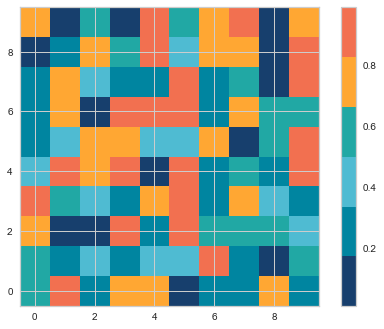

In [9]:
#Define color palette fiting presentation slides

# Define colors by color code
blue_1 = '#4fbbd2'
blue_2 = '#0085a0'
blue_3 = '#173f6d'
green = '#21a8a4'
red = '#f27050'
orange = '#ffa733'

# List of colors 
colors = [blue_3, blue_2, blue_1, green, orange, red]

# assign to Matplotlib colormap
vintage = matplotlib.colors.ListedColormap(colors, name="vintage", N=6)

# plot Matplotlib colors
mat = np.random.random((10,10))
plt.imshow(mat, origin="lower", cmap=vintage, interpolation='nearest')
plt.colorbar()
plt.show()

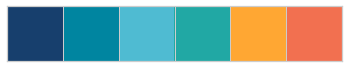

In [10]:
# assign to Seaborn color palette
current_palette = sns.color_palette(colors)

# plot Seaborn colors
sns.palplot(current_palette)
sns.set(palette=current_palette)

### Dataset

The dataset was a kind gift of Hummingbird Diagnostics GmbH (https://www.hummingbird-diagnostics.com) provided by neuefische GmbH (https://www.neuefische.de/)

#### Overview

| Column Name | Description | Type | Others | 
|-------------|-------------|------|--------|
| sampleID | Sample Reference | Object | 300 Samples|
| Group | Sample Label | Categorical | NTLD (Non-Tumour Lung-Disease),<br>LCa (Lung Cancer),<br>CON (CONtrol Group)|
| Sex | Gender | Categorical | male or female|
| Age | Age | Numeric | 34 - 84 |
| Smoke | Smoker | Categorical | present,<br>past,<br>never|
| hsa-let-7a-3p - <br>hsa-miR-99b-5p | miRNA Expression Values | Numeric | 1183 different miRNA 

#### Loading Data and creating a Pandas Dataframe

In [27]:
# Loading Excel-File with Annotation
df1 = pd.read_excel('data/LC_annotation.xlsx')
print('The dataframe consist of {} rows and {} columns.'.format(df1.shape[0], df1.shape[1]))
df1.head()

The dataframe consist of 300 rows and 5 columns.


,sampleID,Group,Sex,Age,Smoke
0,SampleLC_1,NTLD,male,34.0,NaN
1,SampleLC_2,NTLD,female,35.0,NaN
2,SampleLC_3,NTLD,female,37.0,NaN
3,SampleLC_4,LCa,female,43.5,Past
4,SampleLC_5,NTLD,male,44.0,Present


In [28]:
# Info about d(ata)types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sampleID  300 non-null    object 
 1   Group     300 non-null    object 
 2   Sex       294 non-null    object 
 3   Age       297 non-null    float64
 4   Smoke     247 non-null    object 
dtypes: float64(1), object(4)
memory usage: 11.8+ KB


In [29]:
# Loading .txt-File with miRNA-Expression Data
df2 = pd.read_table('data/LC_data_non_log.txt')
print('The dataframe consist of {} rows and {} columns.'.format(df2.shape[0], df2.shape[1]))
df2.head()

The dataframe consist of 1183 rows and 300 columns.


,SampleLC_1,SampleLC_2,SampleLC_3,SampleLC_4,SampleLC_5,SampleLC_6,SampleLC_7,SampleLC_8,SampleLC_9,SampleLC_10,...,SampleLC_291,SampleLC_292,SampleLC_293,SampleLC_294,SampleLC_295,SampleLC_296,SampleLC_297,SampleLC_298,SampleLC_299,SampleLC_300
hsa-let-7a-3p,10.169737,8.993866,9.221781,9.700501,6.133340,7.275606,7.449349,7.883027,5.694632,7.676339,...,10.231375,7.488037,24.502362,6.388280,7.690654,6.299681,10.355813,8.769300,7.280144,7.214706
hsa-let-7a-5p,5717.565532,8152.894560,9161.633060,15589.388815,23861.201568,9901.092307,9353.363102,21256.531275,40763.465605,29245.233210,...,16196.642530,700.533350,8726.485189,22803.481320,25015.375396,22466.730785,11628.542374,136769.972052,26820.547670,26597.044525
hsa-let-7b-3p,15.373312,14.683980,15.751940,11.411269,25.375915,9.623426,17.974963,14.870346,24.793596,18.707404,...,20.736437,17.581660,32.999253,13.348059,18.129165,22.954418,17.644106,13.651284,22.475348,25.833810
hsa-let-7b-5p,2888.175532,3805.584560,1262.754060,7857.315268,9886.602937,2163.823798,4105.700075,16453.774838,20718.366066,10620.324339,...,14533.701990,1972.377350,9391.409855,33118.422360,18110.775679,47644.899330,16593.222849,83604.788124,20045.890411,32703.037481
hsa-let-7c-5p,657.148032,906.707560,301.175060,1510.150845,2891.103594,387.774260,779.223334,4264.195792,6357.348000,2607.322331,...,2154.289849,134.971650,1263.326599,7542.868162,4076.368624,10307.480329,2191.549352,21619.300366,4307.879298,7170.643628


In [30]:
# Info about d(ata)types
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1183 entries, hsa-let-7a-3p to hsa-miR-99b-5p
Columns: 300 entries, SampleLC_1 to SampleLC_300
dtypes: float64(300)
memory usage: 2.7+ MB


#### Joining Data

In [31]:
# Setting Index of df1 (Annotation) to sampleID
df1.set_index("sampleID")

# Transforming columns to rows of df2 (miRNA Expression Data)
df3 = df2.T

# Joining Dataframes to create a single dataframe df4
df4 = df1.join(df3, on="sampleID", how='outer')
print('The dataframe consist of {} rows and {} columns.'.format(df4.shape[0], df4.shape[1]))
df4.head()

The dataframe consist of 300 rows and 1188 columns.


,sampleID,Group,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,SampleLC_1,NTLD,male,34.0,NaN,10.169737,5717.565532,15.373312,2888.175532,657.148032,...,6.390441,7.820884,8.481891,5.932662,112.3047,34.32323,7.073449,14.79587,6.989605,28.41288
1,SampleLC_2,NTLD,female,35.0,NaN,8.993866,8152.894560,14.683980,3805.584560,906.707560,...,5.234970,7.567298,7.847653,5.985716,185.2690,47.13855,5.724681,15.02991,6.412826,13.66082
2,SampleLC_3,NTLD,female,37.0,NaN,9.221781,9161.633060,15.751940,1262.754060,301.175060,...,4.435148,7.738681,7.893889,5.410440,182.6446,66.89235,6.719895,19.68656,7.317585,48.61566
3,SampleLC_4,LCa,female,43.5,Past,9.700501,15589.388815,11.411269,7857.315268,1510.150845,...,7.808394,8.844422,8.782223,8.176937,366.1072,40.31580,8.553054,224.52850,8.869005,66.39760
4,SampleLC_5,NTLD,male,44.0,Present,6.133340,23861.201568,25.375915,9886.602937,2891.103594,...,4.946353,5.378983,6.080522,5.319329,1501.0180,122.96760,5.220272,211.52930,5.563860,99.50221


In [32]:
# Info about d(ata)types
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Columns: 1188 entries, sampleID to hsa-miR-99b-5p
dtypes: float64(1184), object(4)
memory usage: 2.7+ MB


## Data Cleaning

### Missing Values

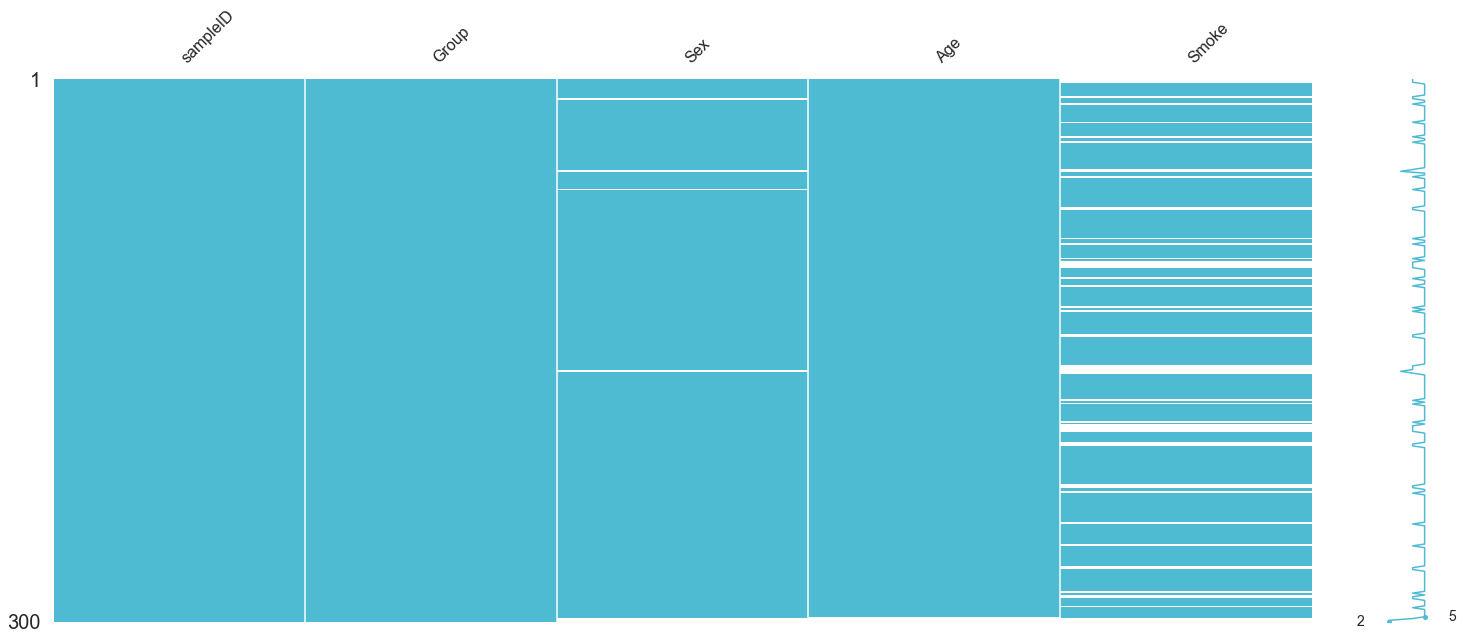

In [33]:
# Check for missing values in df1 (Annotation)
missingno.matrix(df1, color=matplotlib.colors.to_rgb(blue_1));
plt.savefig('figures/missingvalues_annotation', transparent=True, dpi=300);

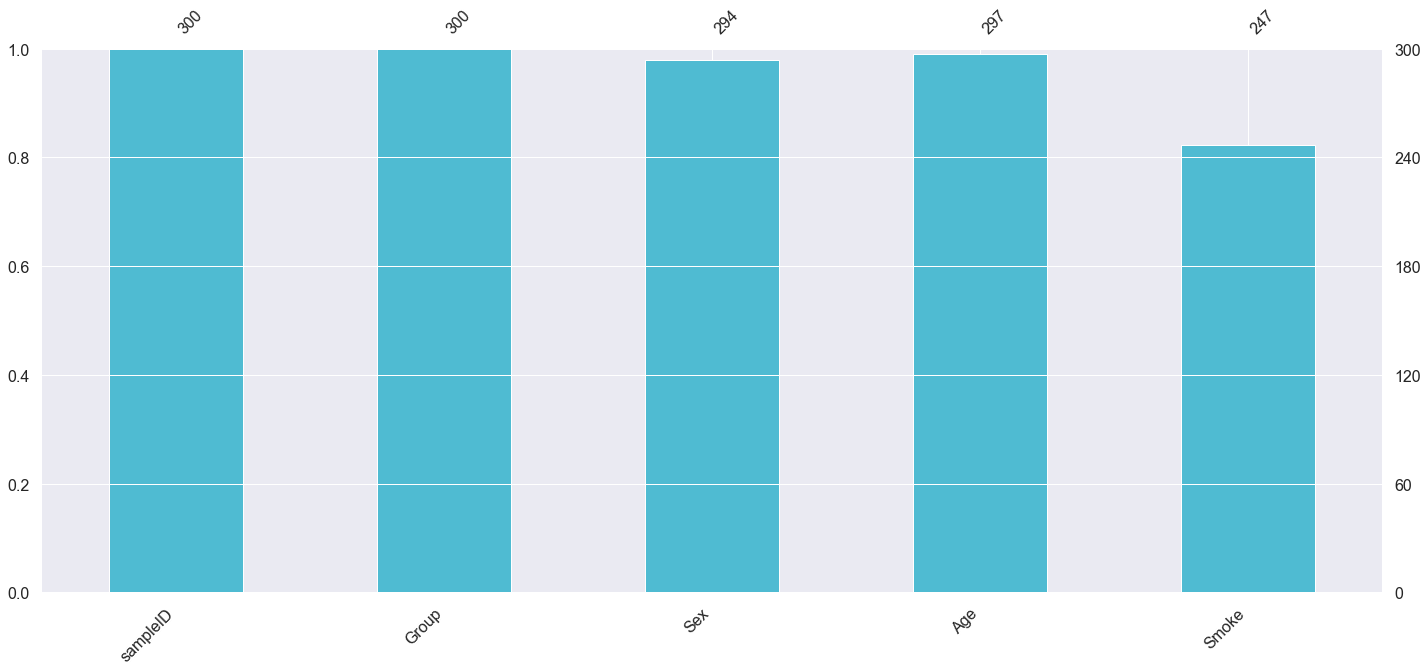

In [34]:
missingno.bar(df1, color=matplotlib.colors.to_rgb(blue_1));
plt.savefig('figures/missingvalues_annotation2', transparent=True, dpi=300);

In [35]:
df1.isna().sum()

sampleID     0
Group        0
Sex          6
Age          3
Smoke       53
dtype: int64

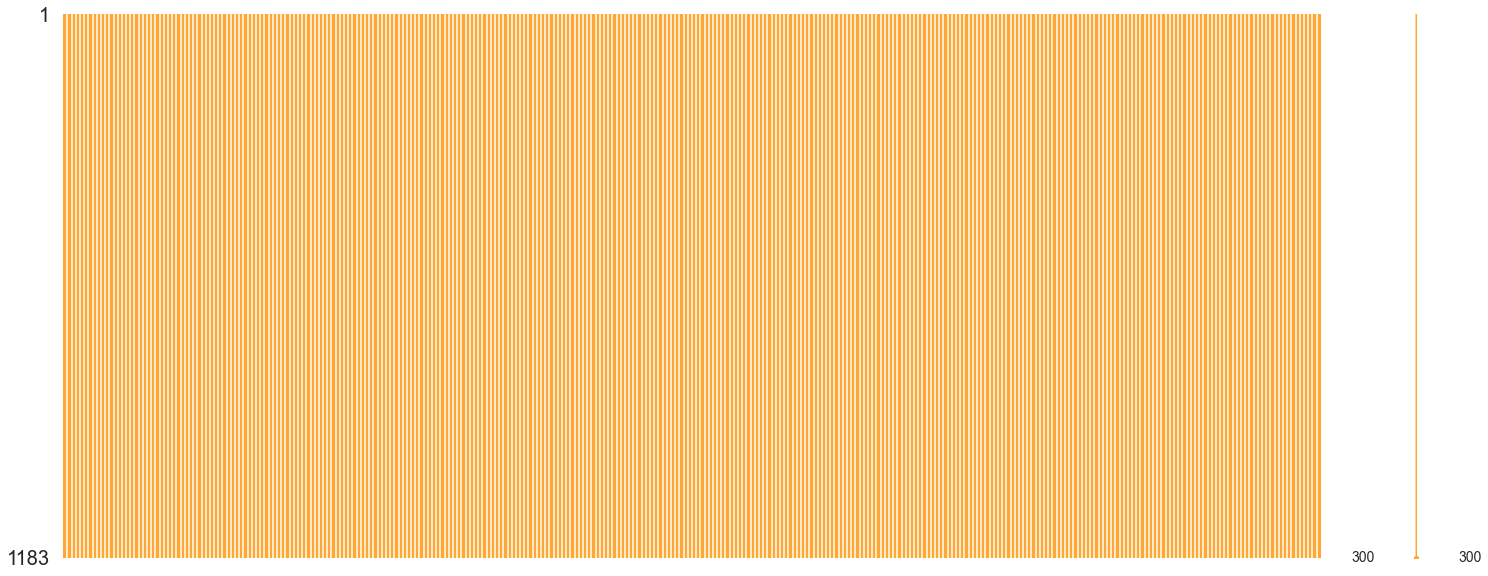

In [38]:
# Check for missing values in df2 (miRNA-Expression Data)
missingno.matrix(df2, color=matplotlib.colors.to_rgb(orange));
plt.savefig('figures/missingvalues_miRNA', transparent=True, dpi=300);

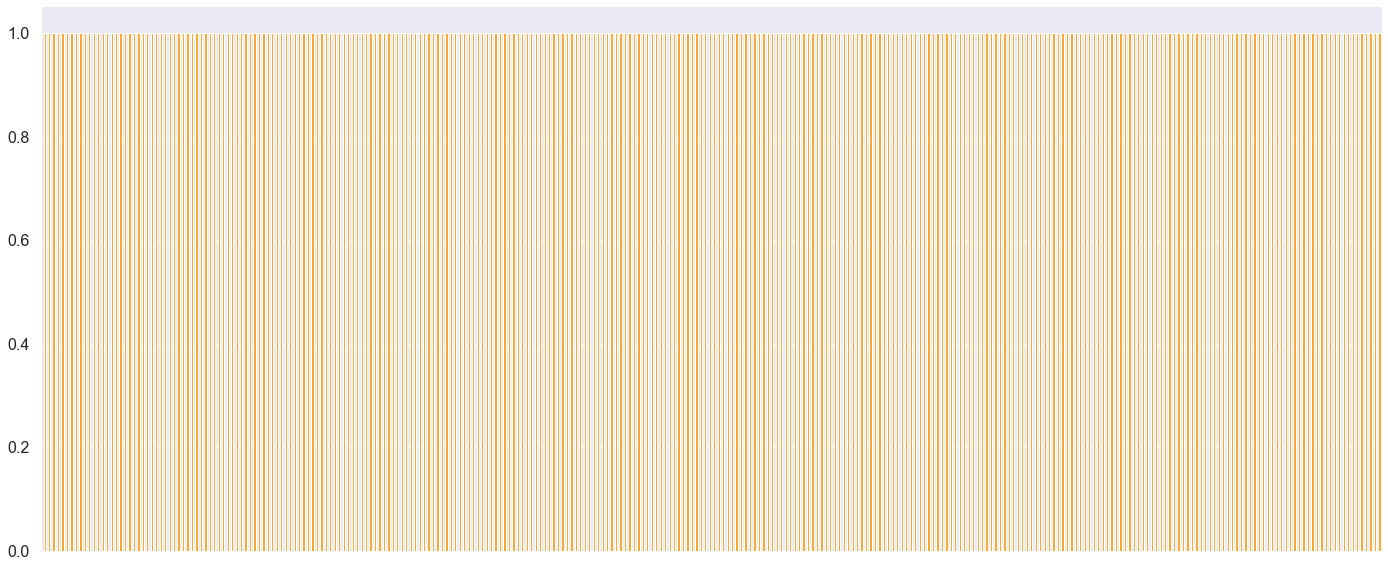

In [39]:
missingno.bar(df2, color=matplotlib.colors.to_rgb(orange));
plt.savefig('figures/missingvalues_miRNA2', transparent=True, dpi=300);

In [40]:
df2.isna().sum()

SampleLC_1      0
SampleLC_2      0
SampleLC_3      0
SampleLC_4      0
SampleLC_5      0
               ..
SampleLC_296    0
SampleLC_297    0
SampleLC_298    0
SampleLC_299    0
SampleLC_300    0
Length: 300, dtype: int64

#### Summary

There are values missing for Sex (6/300; 2%), Age (3/300; 1%) and Smoke (53/300; 17.6%) in Annotation Data and no missing values in miRNA-Expresion Data.

These missing values may be neclected as not necessarily needed for the project goals to use a set of 10 to 20 miRNAs to predict a group of patients. As well miRNA data (Prediction Features) as group (Prediction Labels) show no missing values.

### Cleaning / Converting Values

In [41]:
# Creating new Column Label (encoding Labels to numerical Values 0,1,2; needed in some functions)
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)

# first create list with old labels
label_list = df4.Group.tolist()

# then encode labels to label_new list
label_new = []
for label in label_list:
    if label == "CON":
        label_new.append(0)
    elif label == "LCa":
        label_new.append(1)
    else:
        label_new.append(2)
        
# include new labels to the dataframe
df4.insert(2, "Label", label_new)

## Data Exploration

Visualization of different parts of the dataframe provides a first overview over the properties and distribution of the various features.

### miRNA-Expression Data

In [42]:
# Simple Statistics for each column / over all patients for each miRNA
df3.describe()

,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,hsa-let-7e-5p,hsa-let-7f-1-3p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,9.402791,23832.393325,19.559043,17974.643896,3789.420736,16.142173,6565.580723,8.785773,31.758458,18.074932,...,8.114372,8.384787,8.675664,7.723339,600.038161,123.315892,8.181131,89.346688,8.665373,81.749416
std,5.280378,23291.105557,7.399962,14424.037569,3420.570174,8.283376,6575.586782,5.272169,28.105664,6.824515,...,4.811039,4.945748,4.949045,4.605896,896.650391,193.986571,4.861083,66.851102,5.212743,61.000360
min,4.940617,38.339086,7.450113,42.280062,14.556718,5.587808,7.244910,4.542245,4.921895,7.085688,...,4.100124,4.300865,4.416310,4.048167,5.755420,5.594751,4.440024,6.793955,4.491491,6.019939
25%,6.658562,9516.969027,14.896490,8016.475395,1448.657211,10.925667,2732.859626,6.137592,16.579612,13.577476,...,5.616376,5.809403,6.101095,5.354176,110.089650,40.508820,5.680078,41.061370,5.912016,44.529785
50%,7.628066,17199.351502,17.481272,14156.440842,2963.611225,13.291748,4491.039755,7.117287,24.284067,16.227491,...,6.571538,6.913197,7.046945,6.234828,307.904750,66.225320,6.660271,72.068805,6.998983,69.419520
75%,9.750887,28684.175160,23.934594,26838.248546,4984.884862,18.164330,7913.861504,9.014158,35.380196,21.676177,...,8.578434,8.914393,8.969263,8.007796,674.267025,124.908650,8.234042,116.980850,8.843192,104.322350
max,56.642516,149962.333065,69.576656,83604.788124,21619.300366,61.529077,44740.793541,55.157347,259.268272,68.772438,...,52.471690,53.556260,51.972650,49.352820,8099.504000,1997.999000,50.939600,400.610300,54.590190,589.320900


#### Distribution of miRNA values

In [99]:
# D'Agostino and Pearson's Test on Normal Distribution

# create list of columns of df3
miRNA_stat = df3.columns

# create dictionary for results of D'Agostino and Pearson's Test
miRNA_normal = {}

for miRNA in miRNA_stat:

    # make Pearson Test on Normal distribution
    # statistic = z_score_skew^2 + z_score_kurtosis^2; pvalue = significance
    statistic, pvalue = normaltest(df3[miRNA])
   
    # interpretation
    alpha = 0.05 # 5% significance H0 Hypothesis
    if pvalue > alpha:
        # sample looks Normal distributed (Gaussian fails to reject Zero Hypothesis H0)
        gaussian = 1
    else:
        # sample looks NOT Normal distributed (Gaussian rejects Zero Hypothesis H0)
        gaussian = 0
    
    miRNA_normal[miRNA] = ((round(statistic, 3)), (round(pvalue, 3)), gaussian)

# create dataframe with results dictionary 
miRNA_dist = pd.DataFrame(miRNA_normal).T.rename(columns={0:"z_score", 1:"p_value", 2:"normal"})

In [101]:
# check if or which miRNA is normally distributed in patient samples
miRNA_dist[(miRNA_dist["normal"] == 1)]

,z_score,p_value,normal
hsa-miR-223-3p,5.021,0.081,1.0
hsa-miR-425-5p,4.947,0.084,1.0


count    3.000000e+02
mean     1.191841e+06
std      4.839428e+05
min      7.851522e+04
25%      8.814026e+05
50%      1.183958e+06
75%      1.458039e+06
max      3.506215e+06
Name: sum_miRNA, dtype: float64

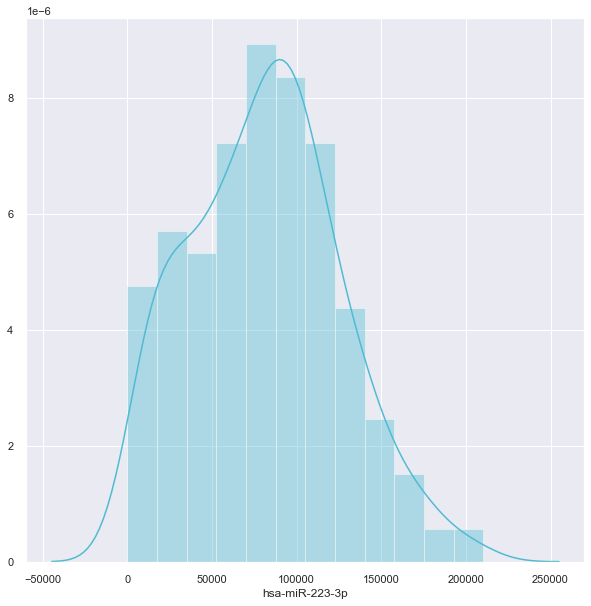

In [105]:
# Histogram for Distribution of miRNA 223-3p
plt.figure(figsize=(10,10))
sns.distplot(df3["hsa-miR-223-3p"], color=blue_1);
plt.savefig('figures/distribution_miRNA_223-3p', transparent=True, dpi=300);
df5.sum_miRNA.describe()

count    3.000000e+02
mean     1.191841e+06
std      4.839428e+05
min      7.851522e+04
25%      8.814026e+05
50%      1.183958e+06
75%      1.458039e+06
max      3.506215e+06
Name: sum_miRNA, dtype: float64

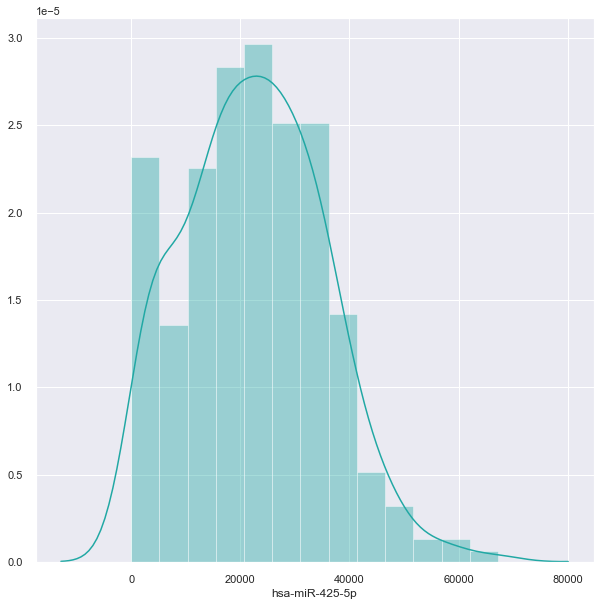

In [107]:
# Histogram for Distribution of miRNA 425-5p
plt.figure(figsize=(10,10))
sns.distplot(df3["hsa-miR-425-5p"], color=green);
plt.savefig('figures/distribution_miRNA_425-5p', transparent=True, dpi=300);
df5.sum_miRNA.describe()

### Sum of miRNA concentration

Checking the data description statement: "...Each column contains the concentration of specific miRNAs, while the sum of all miRNA concentrations per patient is constant..."

In [44]:
df5 = pd.DataFrame(df3.sum(axis=1)).rename(columns={0:"sum_miRNA"})
df5

,sum_miRNA
SampleLC_1,4.581314e+05
SampleLC_2,5.015698e+05
SampleLC_3,6.360268e+05
SampleLC_4,1.520136e+06
SampleLC_5,1.444430e+06
...,...
SampleLC_296,1.596045e+06
SampleLC_297,9.929835e+05
SampleLC_298,2.199376e+06
SampleLC_299,1.911118e+06


count    3.000000e+02
mean     1.191841e+06
std      4.839428e+05
min      7.851522e+04
25%      8.814026e+05
50%      1.183958e+06
75%      1.458039e+06
max      3.506215e+06
Name: sum_miRNA, dtype: float64

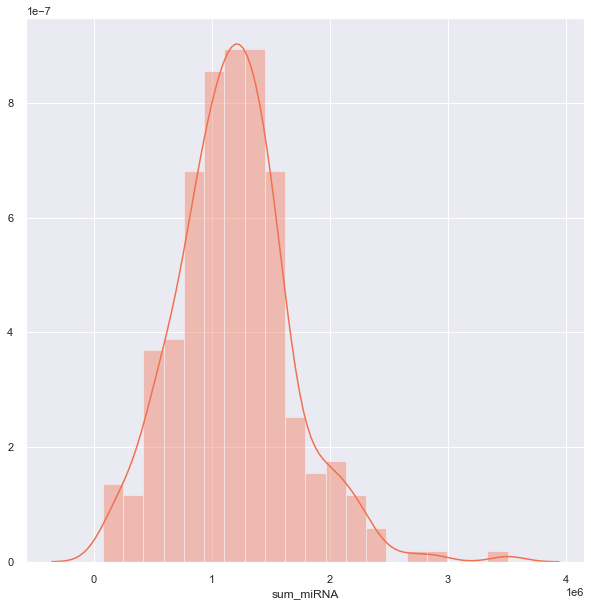

In [45]:
# Histogram for Distribution of Sum of miRNA
plt.figure(figsize=(10,10))
sns.distplot(df5.sum_miRNA, color=red);
plt.savefig('figures/distribution_sum_miRNA', transparent=True, dpi=300);
df5.sum_miRNA.describe()

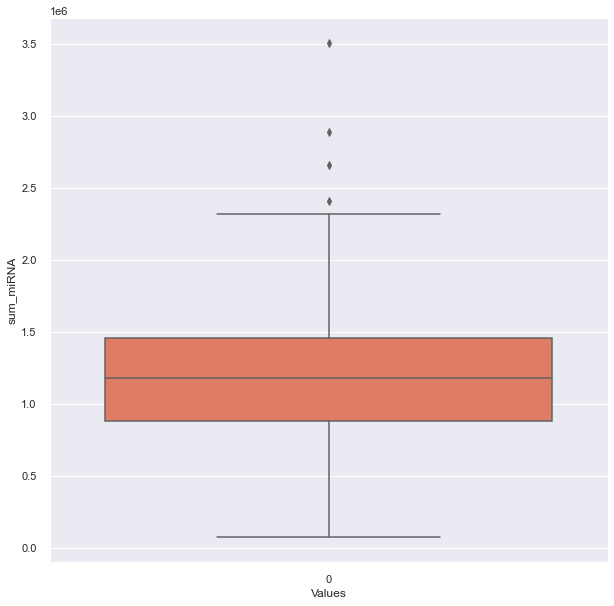

In [46]:
# Boxplot for Sum of miRNA (reveals the presence of outliers)
plt.figure(figsize=(10,10))
sns.boxplot(data=df5.sum_miRNA, color=red)
plt.xlabel('Values');
plt.ylabel('sum_miRNA');
plt.savefig('figures/boxplot_sum_miRNA', transparent=True, dpi=300);

The data discription statement seems to be wrong. I assume the statement refers to the total miRNA concentration after extraction from blood samples, but not all miRNA were covered by analysis (1183 in this dataset, but more than 2000 known in humans. Hammond, 2015: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4504744/pdf/nihms-690138.pdf).

#### Summary

- all of the 1183 miRNAs are not normally distributed in patient samples except 2 are almost (miRNA 223-3p and miRNA 425-5p)
- The sum of miRNAs is almost normally distributed (small subgroup / outliers between 2.3e+06 and 3.5e+06)
- the sum of all miRNAs is not constant per patient sample

### Annotation

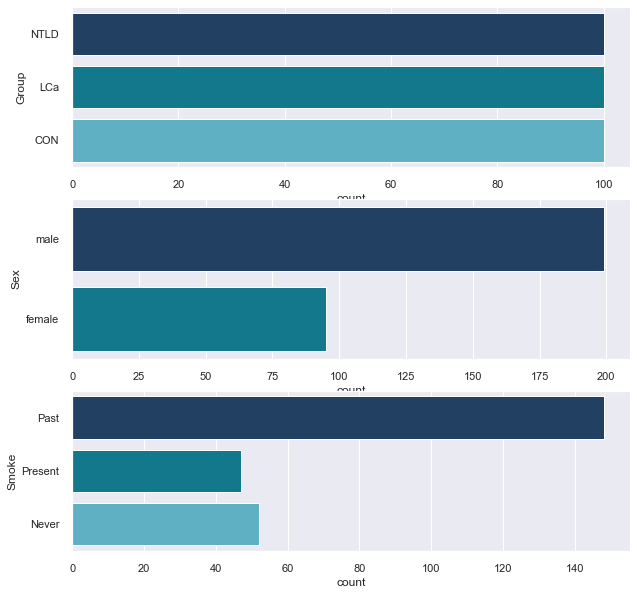

In [47]:
# Plots of Annotation
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

sns.countplot(y=df1.Group, ax=axes[0]);
sns.countplot(y=df1.Sex, ax=axes[1]);
sns.countplot(y=df1.Smoke, ax=axes[2]);
plt.savefig('figures/countplot_annotation', transparent=True, dpi=300);

In [48]:
# Counting Values of Annotation
print(df1.Group.value_counts())
print(df1.Sex.value_counts())
print(df1.Smoke.value_counts())

CON     100
LCa     100
NTLD    100
Name: Group, dtype: int64
male      199
female     95
Name: Sex, dtype: int64
Past       148
Never       52
Present     47
Name: Smoke, dtype: int64


count    297.000000
mean      66.337710
std        8.090426
min       34.000000
25%       62.000000
50%       67.000000
75%       72.000000
max       84.000000
Name: Age, dtype: float64

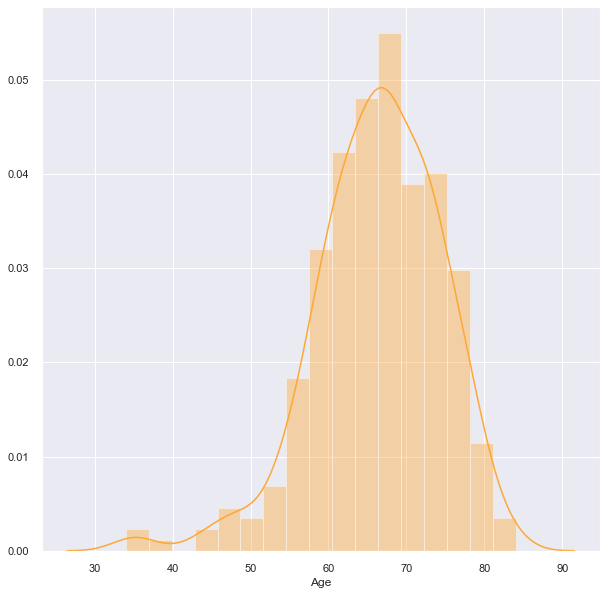

In [49]:
# Histogram for Age Distribution
plt.figure(figsize=(10,10))
sns.distplot(df1.Age, color=orange);
plt.savefig('figures/distribution_age', transparent=True, dpi=300);
df1.Age.describe()

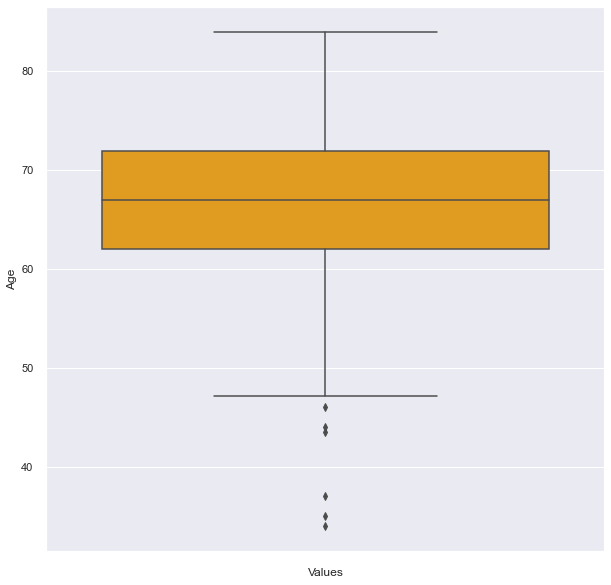

In [50]:
# Boxplot for Age (reveals the presence of outliers)
plt.figure(figsize=(10,10))
sns.boxplot(df1.Age, color="orange", orient="v")
plt.xlabel('Values');
plt.ylabel('Age');
plt.savefig('figures/boxplot_age', transparent=True, dpi=300);

#### Summary

- Groups is equally distributed between NTLD (100/300; 33.3%), LCa (100/300; 33.3%) and CON (100/300; 33.3%) (no imbalances; used as class label)
- more males (199/300; 66.3%) than females (95/300; 31.6%) in cohort (medium inbalance; not used as class label)
- more past smokers (148/300; 49.3%) than present (47/300; 15.6%) and never (52/300; 17.3%) smokers (medium inbalance; not used as class label)
- age is almost normally distributed (small subgroup / outliers between 34 and 47)

## Feature Engineering

### Data Selection miRNA-Expression Data

In [ ]:
# Not Required Columns of complete DataFrame df4 to List
col = ['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']

# Creating y and X
y = df4['Label']
X = df4.drop(col, axis=1)

### Scaling miRNA-Expression Data

As scaling might provide a useful tool in data preprocessing even if the values are

In [ ]:
# Scaling didn´t improve the models, but I haven´t adjusted the optimisation
# if so maybe some things change

In [ ]:
# Scaling the data to try to improve modeling

# Initialize Scaler and transform data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create scaled dataframe
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Switch X to X_scaled (comment out for unscaled data)
# X = X_scaled

In [ ]:
# Then update dataframe df4 with scaled data / unscaled data
df4 = pd.concat([df4[col], X], axis=1)

#### Eval/Train-Test-Split

In [ ]:
# Separating data for final evaluation (Eval-Test-Set)
X_modell, X_eval, y_modell, y_eval = train_test_split(X, y, test_size=0.1, random_state=seed)

# X_model and X_eval 
print('Shape X_modell:', X_modell.shape)
print('Shape X_eval:', X_eval.shape)

In [ ]:
# Train Test Split

# We have 1183 predictive features. The rule of thumb is 50 records per feature... 
# So we need to have at least 59,150 records in this dataset, but we only have 270 records!
# Because there are only 300 samples, we cannot reach this even without splitting!
# As our aim is to reduce the number of features between 10 to 20, then only 500 to 1000 records are needed.
# This will be more agreeable.

# choosing test size to same size as X_eval
X_train, X_test, y_train, y_test = train_test_split(X_modell, y_modell, test_size=0.11, random_state=seed)

# X_train and X_test
print('Shape X_train:', X_train.shape)
print('Shape X_test:', X_test.shape)

### Feature Selection from miRNA-Expression Data

#### Feature Importance of tree-based Classifiers

In [ ]:
# Initialize Tree-based Classifiers
DTC = DecisionTreeClassifier(random_state=seed) 
RFC = RandomForestClassifier(random_state=seed) 
ETC = ExtraTreesClassifier(random_state=seed)
ABC = AdaBoostClassifier(random_state=seed)
XGBC = XGBClassifier(random_state=seed)

# List of Tree-based Classifiers used for feature Selection
tree_clf = [DTC, RFC, ETC, ABC, XGBC]

# List of Classifier Names
name_clf = ["DTC", "RFC", "ETC", "ABC", "XGBC"]

In [ ]:
%%capture

# Create Dictionary for Feature Selection Results
results_fs = {}

# Use feature_selection function 
feature_selection(results_fs, tree_clf, name_clf, X_train, y_train)

##### Visualisation of Feature Importance of tree-based Classifiers

In [ ]:
# Making Dataframes from results_fs Dictionary
dtc_dataframe = pd.DataFrame(results_fs["DTC"]).rename(columns={0:"miRNA", 1:"importance_value"})
rfc_dataframe = pd.DataFrame(results_fs["RFC"]).rename(columns={0:"miRNA", 1:"importance_value"})
etc_dataframe = pd.DataFrame(results_fs["ETC"]).rename(columns={0:"miRNA", 1:"importance_value"})
abc_dataframe = pd.DataFrame(results_fs["ABC"]).rename(columns={0:"miRNA", 1:"importance_value"})
xgbc_dataframe = pd.DataFrame(results_fs["XGBC"]).rename(columns={0:"miRNA", 1:"importance_value"})

In [ ]:
# Plots for Feature Selection
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 30))

ax1.set_title("Feature Selection Decision Tree Classifier")
ax2.set_title("Feature Selection Random Forrest Classifier")
ax3.set_title("Feature Selection Extra Tree Classifier")
ax4.set_title("Feature Selection Ada Boost Classifier")
ax5.set_title("Feature Selection XG Boost Classifier")


sns.barplot(y="miRNA", x="importance_value", data=dtc_dataframe, ax=ax1, palette=current_palette);
sns.barplot(y="miRNA", x="importance_value", data=rfc_dataframe, ax=ax2, palette=current_palette);
sns.barplot(y="miRNA", x="importance_value", data=etc_dataframe, ax=ax3, palette=current_palette); 
sns.barplot(y="miRNA", x="importance_value", data=abc_dataframe, ax=ax4, palette=current_palette);
sns.barplot(y="miRNA", x="importance_value", data=xgbc_dataframe, ax=ax5, palette=current_palette);
plt.savefig('figures/feature_selection', transparent=True, dpi=300);

##### Combination of tree-based Classifiers (TBC)

In [ ]:
%%capture

# Create a new Dictionary for Feature Selection Results 
# from tree-based Classifiers which includes all values (n=None)
results_combination = {}

# Use feature_selection function 
feature_selection(results_combination, tree_clf, name_clf, X_train, y_train, n=None)

In [ ]:
# Making Dataframes from results_combination Dictionary
dtc_combi = pd.DataFrame(results_combination["DTC"]).rename(columns={0:"miRNA_dtc", 1:"iv_dtc"})
rfc_combi = pd.DataFrame(results_combination["RFC"]).rename(columns={0:"miRNA_rfc", 1:"iv_rfc"})
etc_combi = pd.DataFrame(results_combination["ETC"]).rename(columns={0:"miRNA_etc", 1:"iv_etc"})
abc_combi = pd.DataFrame(results_combination["ABC"]).rename(columns={0:"miRNA_abc", 1:"iv_abc"})
xgbc_combi = pd.DataFrame(results_combination["XGBC"]).rename(columns={0:"miRNA_xgbc", 1:"iv_xgbc"})

In [ ]:
# Sort Dataframes by miRNA
dtc_combi = dtc_combi.sort_values(by ='miRNA_dtc', axis=0 ).reset_index()
rfc_combi = rfc_combi.sort_values(by ='miRNA_rfc', axis=0 ).reset_index()
etc_combi = etc_combi.sort_values(by ='miRNA_etc', axis=0 ).reset_index()
abc_combi = abc_combi.sort_values(by ='miRNA_abc', axis=0 ).reset_index()
xgbc_combi = xgbc_combi.sort_values(by ='miRNA_xgbc', axis=0 ).reset_index()

In [ ]:
# and combine all Dataframes in 1 dataframe
df_combi = pd.concat([dtc_combi, rfc_combi, etc_combi, abc_combi, xgbc_combi], axis=1)

In [ ]:
# then drop all columns not needed
drop_col = ["index", "miRNA_rfc", "miRNA_etc", "miRNA_abc", "miRNA_xgbc"]
df_combi = df_combi.drop(drop_col, axis=1)

# rename "miRNA_dtc" to miRNA
df_combi = df_combi.rename(columns={"miRNA_dtc":"miRNA"})

# set new index
df_combi = df_combi.set_index("miRNA")

# calculate the sum of all importance values for each miRNA
series_combi = df_combi.sum(axis=1)

# sort descending by Importance Value
series_combi = series_combi.sort_values(ascending=False)

# make a list of tuples
list_combi = list(series_combi.items())

In [ ]:
# select the new TOP n (default=20)
n=20
list_combi = list_combi[0:n]

In [ ]:
# create a new results dictionary in the common format (TBC = all Tree-Based Classifiers)
results_TBC = {"TBC":list_combi}

##### Visualisation of Combination of tree-based Classifiers

In [ ]:
# Making Dataframes from results_TBC Dictionary
tbc_dataframe = pd.DataFrame(results_TBC["TBC"]).rename(columns={0:"miRNA", 1:"importance_value"})

In [ ]:
# Plots for Feature Selection
ax6 = sns.barplot(y="miRNA", x="importance_value", data=tbc_dataframe, palette=current_palette)
ax6.set_title("Feature Selection Combination Tree-Based Classifier");
plt.savefig('figures/feature_selection_combination', transparent=True, dpi=300);

#### Recursive Feature Elimination (RFE) with non-tree-based Classifiers

In [ ]:
# Classifier Models for Recursive Feature Elemination
# (estimator is fitted recursive with "step=1" less Features
# and Features are ranked based on their contribution/importance)

#Initilizing non-tree-based Classifier Models
LG2 = LogisticRegression(random_state=seed)
SGDC2 = SGDClassifier(random_state=seed)   
    
# List of non-tree-based Classifiers used for Feature Selection
non_tree_clf = [LG2, SGDC2]

# List of non-tree-based Classifiers names
nt_name_clf = ["LG", "SGDC"]

In [ ]:
%%capture

# Create Dictionary for Feature Selection Results
results_nt_clf = {}

# Use funtion for RFE based feature selection
rfe_selection(results_nt_clf, non_tree_clf, nt_name_clf, X_train, y_train)

### Data Selection TOP20 Features from miRNA-Expression Data

#### TOP20 Features Decision Tree Classifier (DTC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_dtc_top20 = dataframe_selection(results_fs["DTC"], X_train=X_train)

#### TOP20 Features  Random Forrest Classifier (RFC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_rfc_top20 = dataframe_selection(results_fs["RFC"], X_train=X_train)

#### TOP20 Features  Extra Tree Classifier (ETC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_etc_top20 = dataframe_selection(results_fs["ETC"], X_train=X_train)

#### TOP20 Features Ada Boost Classifier (ABC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_abc_top20 = dataframe_selection(results_fs["ABC"], X_train=X_train)

#### TOP20 Features  XG Boost Classifier (XGBC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_xgbc_top20 = dataframe_selection(results_fs["XGBC"], X_train=X_train)

#### TOP20 Features Combination of tree-based Classifiers (TBC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_tbc_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_train)

#### TOP20 Features Logistic Regression Classifier (LGC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_lgc_top20 = dataframe_selection(results_nt_clf["LG"], X_train=X_train)

#### TOP20 Features SGD Classifer (SGDC)

In [ ]:
# use dataframe_selection function for creating new dataframe
X_sgdc_top20 = dataframe_selection(results_nt_clf["SGDC"], X_train=X_train)

### Data Selection Annotation

#### Sex

In [ ]:
# create new dataframe
df_sex = df4.copy()

In [ ]:
# First I need to exclude some Samples as they are missing values for Sex.
# As these are only 6 values I decide to drop them from the dataframe

In [ ]:
# check for SampleIDs of the missing values for Sex
print(df_sex.shape)
df_sex[(df_sex["Sex"] != "male") & (df_sex["Sex"] != "female")]

In [ ]:
# Drop Instances from People without Sex Annotation
df_sex.drop([11, 51, 61, 161, 298, 299] , axis=0, inplace=True)

In [ ]:
# As Sex is a categorical I need to convert it to a dummy variable
# thise means 1 = male and 0 = female

sex_dummies = pd.get_dummies(df_sex.Sex, drop_first=True)

In [ ]:
# include it to the dataframe
df_sex = pd.concat([sex_dummies, df_sex], axis=1)

In [ ]:
# Not Required Columns of complete DataFrame df_sex to List
col_sex = ['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']

# Creating y and X
y_sex = df_sex['Label']
X_sex = df_sex.drop(col_sex, axis=1)

##### Eval/Train-Test-Split

In [ ]:
# Separating data as before 

# Eval-Test-Set
X_sex_modell, X_sex_eval, y_sex_modell, y_sex_eval = train_test_split(X_sex, y_sex, test_size=0.1, random_state=seed)

# Train-Test-Split
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(X_sex_modell, y_sex_modell, test_size=0.11, random_state=seed)

#### Age

In [ ]:
# maybe the part below has to move to feature engineering

In [ ]:
# create new dataframe
df_age = df4.copy()

In [ ]:
# First I need to exclude some Samples as they are missing values for Sex.
# As these are only 3 values I decide to drop them from the dataframe

In [ ]:
# check for SampleIDs of the missing values for Age
print(df_age.shape)
df_age[df_age["Age"].isna()]

In [ ]:
# Drop Instances from People without Age Annotation
df_age.drop([297, 298, 299] , axis=0, inplace=True)

In [ ]:
# As we have a small subgroup / outliers between 34 and 47 check how many values this are
df_age[df_age["Age"] <= 47]

In [ ]:
# As these are only 6 values I decide to drop them also from the dataframe

# Drop Instances from People without Age < 40 Annotation
df_age.drop([0, 1, 2, 3, 4, 5] , axis=0, inplace=True)

In [ ]:
# Check Histogram for Age Distribution again
plt.figure(figsize=(10,10))
sns.distplot(df_age.Age, color=red);
plt.savefig('figures/distribution_age_nan', transparent=True, dpi=300);
df_age.Age.describe()

In [ ]:
# Boxplot for Age again (reveals the presence of outliers)
plt.figure(figsize=(10,10))
sns.boxplot(df_age.Age, color=red, orient="v")
plt.xlabel('Values');
plt.ylabel('Age');
plt.savefig('figures/boxplot_age_nan', transparent=True, dpi=300);

In [ ]:
# Not Required Columns of complete DataFrame df_sex to List
col_age = ['sampleID', 'Group', 'Label', 'Sex', 'Smoke']

# Creating y and X
y_age = df_age['Label']
X_age = df_age.drop(col_age, axis=1)

##### Eval/Train-Test-Split

In [ ]:
# Separating data as before 

# Eval-Test-Set
X_age_modell, X_sex_eval, y_age_modell, y_age_eval = train_test_split(X_age, y_age, test_size=0.1, random_state=seed)

# Train-Test-Split
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age_modell, y_age_modell, test_size=0.11, random_state=seed)

#### Sex + Age

In [ ]:
# maybe the part below has to move to feature engineering

In [ ]:
# create new dataframe
df_sexage = df_age.copy()

In [ ]:
# First I need to exclude some Samples as they are missing values for Sex.
# As these are only 4 values I decide to drop them from the dataframe

In [ ]:
# check for SampleIDs of the missing values for Sex
print(df_sexage.shape)
df_sexage[(df_sexage["Sex"] != "male") & (df_sexage["Sex"] != "female")]

In [ ]:
# Drop Instances from People without Sex Annotation
df_sexage.drop([11, 51, 61, 161] , axis=0, inplace=True)

In [ ]:
# Again as Sex is a categorical I need to convert it to a dummy variable
# thise means 1 = male and 0 = female

sexage_dummies = pd.get_dummies(df_sexage.Sex, drop_first=True)

In [ ]:
# include it to the dataframe
df_sexage = pd.concat([sexage_dummies, df_sexage], axis=1)

In [ ]:
# Not Required Columns of complete DataFrame df_sex to List
col_sexage = ['sampleID', 'Group', 'Label', 'Sex', 'Smoke']

# Creating y and X
y_sexage = df_sexage['Label']
X_sexage = df_sexage.drop(col_sexage, axis=1)

##### Eval/Train-Test-Split

In [ ]:
# Separating data as before 

# Eval-Test-Set
X_sexage_modell, X_sexage_eval, y_sexage_modell, y_sexage_eval = train_test_split(X_sexage, y_sexage, test_size=0.1, random_state=seed)

# Train-Test-Split
X_sexage_train, X_sexage_test, y_sexage_train, y_sexage_test = train_test_split(X_sexage_modell, y_sexage_modell, test_size=0.11, random_state=seed)

#### Smoke

In [ ]:
# Even if it is not usefull or reasonable to use the Smoke annotation as
# predicting value, I would like to check it to be comprehensiv

In [ ]:
# maybe the part below has to move to feature engineering

In [ ]:
# create new dataframe
df_smoke = df4.copy()

In [ ]:
# First I need to exclude Samples as they are missing values for Smoke.
# Unfortunately there are 53 Samples, but I decide to drop them from the dataframe

In [ ]:
# check for SampleIDs of the missing values
print(df_smoke.shape)
df_smoke[df_smoke["Smoke"].isna()]

In [ ]:
# Drop Instances from People without Smoke Annotation
df_smoke.dropna(subset=["Smoke"], how="any",axis=0, inplace=True)

In [ ]:
# As Smoke is a categorical I need to convert it to a dummy variable
# this means Past = 0 or 1; Present = 0 or 1; Never = both 0

smoke_dummies = pd.get_dummies(df_smoke.Smoke, drop_first=True)

In [ ]:
# include it to the dataframe
df_smoke = pd.concat([smoke_dummies, df_smoke], axis=1)

In [ ]:
# Not Required Columns of complete DataFrame df_smoke to List
col_smoke = ['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']

# Creating y and X
y_smoke = df_smoke['Label']
X_smoke = df_smoke.drop(col_smoke, axis=1)

##### Eval/Train-Test-Split

In [ ]:
# Separating data as before 

# Eval-Test-Set
X_smoke_modell, X_smoke_eval, y_smoke_modell, y_smoke_eval = train_test_split(X_smoke, y_smoke, test_size=0.1, random_state=seed)

# Train-Test-Split
X_smoke_train, X_smoke_test, y_smoke_train, y_smoke_test = train_test_split(X_smoke_modell, y_smoke_modell, test_size=0.11, random_state=seed)

## Predictive Modelling

### Metric

For our purpose **precision** seems to be a good metric for several reasons.<br>  <br>  <br>In summary, precision seems to be a good metric because lung cancer is a very abundant disease with bad prognosis at advanced stages, which makes an annual screening method with low risks for the patient reasonable. As existing methods which could be used for screenings cause radiation exposure with high FPR and therefore overdiagnosis with economic burden and patient anxiety a method with **high precision to detect lung cancer** is needed.<br>  <br>Here I will optimize the prediction models on precision to detect lung cancer for the stated reasons. As there is a trade-off between precision and recall (high threshold will lead to high precision but low recall and vice versa) the threshold could be adjusted depending on stakeholders interests. Thus the ROC and the ROC AUC values are also used to compare the models.

### Model Selection from different Classifier

In [ ]:
# Initialize Classifier Models
DC = DummyClassifier(random_state=seed) # The Dummy Classifier is used as Baseline Model
LG = LogisticRegression(random_state=seed)
SGDC1 = SGDClassifier(random_state=seed, loss='modified_huber')
KNN1 = KNeighborsClassifier()
GNB = GaussianNB()
SVC1 = SVC(random_state=seed, probability=True)
DTC1 = DecisionTreeClassifier(random_state=seed)
RFC1 = RandomForestClassifier(random_state=seed) 
ETC1 = ExtraTreesClassifier(random_state=seed)
ABC1 = AdaBoostClassifier(random_state=seed)
XGBC1 = XGBClassifier(random_state=seed)

# List for models to be evaluated
model_clf = [DC, LG, SGDC1, KNN1, GNB, SVC1, DTC1, RFC1, ETC1, ABC1, XGBC1]

# List for model names
name_model = ["DC", "LG", "SGDC", "KNN", "GNB", "SVC", "DTC", "RFC", "ETC", "ABC", "XGBC"]

#### without Feature Selection

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_all = {}

# Use model_evaluation function with complete Dataset (X_train = all Features, y_train)
model_evaluation(results_all, model_clf, name_model, X_train, y_train)

###### Visualisation Model Selection

In [ ]:
# Create Dataframe from Crossvalidation Results
cv_dataframe = pd.DataFrame(results_all).T
cv_dataframe

In [ ]:
# Plots for Model Selection
f, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(y=cv_dataframe.Accuracy, x=cv_dataframe.index, ax=axes[0][0], palette=current_palette);
sns.barplot(y=cv_dataframe.Roc_AUC, x=cv_dataframe.index, ax=axes[1][0], palette=current_palette);
sns.barplot(y=cv_dataframe.Precision, x=cv_dataframe.index, ax=axes[0][1], palette=current_palette);
sns.barplot(y=cv_dataframe.F1, x=cv_dataframe.index, ax=axes[1][1], palette=current_palette);

axes[0][0].set_title("Model Selection Accuracy");
axes[1][0].set_title("Model Selection Roc_AUC");
axes[0][1].set_title("Model Selection Precision");
axes[1][1].set_title("Model Selection F1");
plt.savefig('figures/model_selection', transparent=True, dpi=300);

#### with Feature Selection

###### TOP20 Features Decision Tree Classifier (DTC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_dtc_top20 = {}

# Use model_evaluation function with TOP20 DTC Features Dataset (X_dtc_top20, y_train)
model_evaluation(results_dtc_top20, model_clf, name_model, X_dtc_top20, y_train)

###### TOP20 Features Random Forrest Classifier (RFC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_rfc_top20 = {}

# Use model_evaluation function with TOP20 RFC Features Dataset (X_rfc_top20, y_train)
model_evaluation(results_rfc_top20, model_clf, name_model, X_rfc_top20, y_train)

###### TOP20 Features Extra Tree Classifier (ETC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_etc_top20 = {}

# Use model_evaluation function with TOP20 ETC Features Dataset (X_etc_top20, y_train)
model_evaluation(results_etc_top20, model_clf, name_model, X_etc_top20, y_train)

###### TOP20 Features Ada Boost Classifier (ABC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_abc_top20 = {}

# Use model_evaluation function with TOP20 ABC Features Dataset (X_abc_top20, y_train)
model_evaluation(results_abc_top20, model_clf, name_model, X_abc_top20, y_train)

###### TOP20 Features XG Boost Classifier (XGBC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_xgbc_top20 = {}

# Use model_evaluation function with TOP20 XGBC Features Dataset (X_xgbc_tree_top20, y_train)
model_evaluation(results_xgbc_top20, model_clf, name_model, X_xgbc_top20, y_train)

###### TOP20 Features Combination of tree-based Classifiers (TBC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_tbc_top20 = {}

# Use model_evaluation function with TOP20 TBC Features Dataset (X_tbc_top20, y_train)
model_evaluation(results_tbc_top20, model_clf, name_model, X_tbc_top20, y_train)

###### TOP20 Features Logistic Regression Classifier (LGC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_lgc_top20 = {}

# Use model_evaluation function with TOP20 LGC Features Dataset (X_lgc_top20, y_train)
model_evaluation(results_lgc_top20, model_clf, name_model, X_lgc_top20, y_train)

###### TOP20 Features SGD Classifier (SGDC)

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_sgdc_top20 = {}

# Use model_evaluation function with TOP20 SGDC Features Dataset (X_sgdc_top20, y_train)
model_evaluation(results_sgdc_top20, model_clf, name_model, X_sgdc_top20, y_train)

###### Visualisation Model Selection with TOP20 Features

In [ ]:
#create Lists with Labels for Plotting
labels_TOP20 = ["ALL", 
              "TOP20 DTC", 
              "TOP20 RFC", 
              "TOP20 ETC", 
              "TOP20 ABC", 
              "TOP20 XGBC", 
              "TOP20 TBC",
              "TOP20 LGC", 
              "TOP20 SGDC",
             ]

labels_model = name_model

*Precision*

In [ ]:
#Create Dataframe with all Results for Precision
results_precision = pd.DataFrame()

#Enter Results
results_precision["ALL"] = pd.DataFrame(results_all).T.Precision
results_precision["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.Precision
results_precision["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.Precision
results_precision["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.Precision
results_precision["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.Precision
results_precision["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.Precision
results_precision["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.Precision
results_precision["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.Precision
results_precision["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.Precision

results_precision

In [ ]:
# set height of bars for precision
bars_heights_precision = [results_precision["ALL"]
                            , results_precision["TOP20 DTC"]
                            , results_precision["TOP20 RFC"]
                            , results_precision["TOP20 ETC"]
                            , results_precision["TOP20 ABC"]
                            , results_precision["TOP20 XGBC"]
                            , results_precision["TOP20 TBC"]
                            , results_precision["TOP20 LGC"]
                            , results_precision["TOP20 SGDC"]
                         ]

# set size of figure
plt.figure(figsize=(15,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_precision, labels_TOP20, name=labels_model, title="Precision", xlb="Model")
plt.savefig('figures/model_combi_precision', transparent=True, dpi=300);

In [ ]:
# get the 5 (default n=3) best model + feature selection combinations for Precision using top_model function
top_model(results_precision, n=5)

*Accuracy*

In [ ]:
#Create Dataframe with all Results for Accuracy
results_accuracy = pd.DataFrame()

#Enter Results
results_accuracy["ALL"] = pd.DataFrame(results_all).T.Accuracy
results_accuracy["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.Accuracy
results_accuracy["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.Accuracy
results_accuracy["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.Accuracy
results_accuracy["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.Accuracy
results_accuracy["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.Accuracy
results_accuracy["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.Accuracy
results_accuracy["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.Accuracy
results_accuracy["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.Accuracy

results_accuracy

In [ ]:
# set height of bars for accuracy
bars_heights_accuracy = [results_accuracy["ALL"]
                            , results_accuracy["TOP20 DTC"]
                            , results_accuracy["TOP20 RFC"]
                            , results_accuracy["TOP20 ETC"]
                            , results_accuracy["TOP20 ABC"]
                            , results_accuracy["TOP20 XGBC"]
                            , results_accuracy["TOP20 TBC"]
                            , results_accuracy["TOP20 LGC"]
                            , results_accuracy["TOP20 SGDC"]
                        ]

# set size of figure
plt.figure(figsize=(15,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_accuracy, labels_TOP20, name=labels_model, title="Accuracy", xlb="Model")
plt.savefig('figures/model_combi_accuracy', transparent=True, dpi=300);

In [ ]:
# get the 5 (default n=3) best model + feature selection combinations for Accuracy using top_model function
top_model(results_accuracy, n=5)

# here RFC + TOP20 TBC has exactly the same value as ETC + TOP20 TBC
# that´s why it is displayd 2 times

*Roc_AUC*

In [ ]:
#Create Dataframe with all Results for Roc_AUC
results_Roc_AUC = pd.DataFrame()

#Enter Results
results_Roc_AUC["ALL"] = pd.DataFrame(results_all).T.Roc_AUC
results_Roc_AUC["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.Roc_AUC

results_Roc_AUC

In [ ]:
# set height of bars for Roc_AUC
bars_heights_Roc_AUC = [results_Roc_AUC["ALL"]
                            , results_Roc_AUC["TOP20 DTC"]
                            , results_Roc_AUC["TOP20 RFC"]
                            , results_Roc_AUC["TOP20 ETC"]
                            , results_Roc_AUC["TOP20 ABC"]
                            , results_Roc_AUC["TOP20 XGBC"]
                            , results_Roc_AUC["TOP20 TBC"]
                            , results_Roc_AUC["TOP20 LGC"]
                            , results_Roc_AUC["TOP20 SGDC"]
                       ]

# set size of figure
plt.figure(figsize=(15,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_Roc_AUC, labels_TOP20, name=labels_model, title="Roc_AUC", xlb="Model")
plt.savefig('figures/model_combi_roc_auc', transparent=True, dpi=300);

In [ ]:
# get the 5 (default n=3) best model + feature selection combinations for Roc_AUC using top_model function
top_model(results_Roc_AUC, n=5)

*F1*

In [ ]:
#Create Dataframe with all Results for F1
results_F1 = pd.DataFrame()

#Enter Results
results_F1["ALL"] = pd.DataFrame(results_all).T.F1
results_F1["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.F1
results_F1["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.F1
results_F1["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.F1
results_F1["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.F1
results_F1["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.F1
results_F1["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.F1
results_F1["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.F1
results_F1["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.F1

results_F1

In [ ]:
# set height of bars for F1
bars_heights_F1 = [results_F1["ALL"]
                            , results_F1["TOP20 DTC"]
                            , results_F1["TOP20 RFC"]
                            , results_F1["TOP20 ETC"]
                            , results_F1["TOP20 ABC"]
                            , results_F1["TOP20 XGBC"]
                            , results_F1["TOP20 TBC"]
                            , results_F1["TOP20 LGC"]
                            , results_F1["TOP20 SGDC"]
                  
                  ]

# set size of figure
plt.figure(figsize=(15,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_F1, labels_TOP20, name=labels_model, title="F1", xlb="Model")
plt.savefig('figures/model_combi_f1', transparent=True, dpi=300);

In [ ]:
# get the 5 (default n=3) best model + feature selection combinations for F1 using top_model function
top_model(results_F1, n=5)

In [ ]:
# Best Feature Selection: TOP20 TBC
# Best Models: ETC, RFC, XGBC

In [ ]:
# If StandardScaler is used TOP1 is LG with ALL Features
# but this is not an Option as I would like to reduce
# that´s why I am making no changes below (maybe adjust parameters again)

### Model Optimization

In [ ]:
# As the aimed metric is precision I will optimize on precision

#### Random Search Grid Parameters

In [ ]:
# With TOP20 TBC as the chosen feature selection create a new X_test

# use dataframe_selection function for creating new dataframe
X_tbc_top20_test = dataframe_selection(results_TBC["TBC"], X_train=X_test)

In [ ]:
# Stop Switch (comment out to run the steps below)
sys.exit("Stop without Steps below!")

##### Random Search Random Forrest Classifier (RFC)

In [ ]:
# First use random search to check a broad range of parameters

# Initialize Classifier Model
RFC2 = RandomForestClassifier(random_state=seed) # =model

# Set Hyperparameter grid for Model with alternatives to default values (included in grid)
parameters_RFC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 5, 10],
    'n_estimators': [100, 400, 700, 1000, 1300, 1600],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(RFC2, parameters_RFC, X_tbc_top20, y_train, X_tbc_top20_test, y_test, seed=seed)

In [ ]:
# Second use random search to narrow down the range of parameters

# Set new Hyperparameter grid for Model
parameters_RFC_new = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 8, 10, 12, 14, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_estimators': [100, 1100, 1200, 1300, 1400, 1500],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(RFC2, parameters_RFC_new, X_tbc_top20, y_train, X_tbc_top20_test, y_test, seed=seed)

##### Random Search Extra Tree Classifier (ETC)

In [ ]:
# First use random search to check a broad range of parameters

# Initialize Classifier Model
ETC2 = ExtraTreesClassifier(random_state=seed) # =model

# Set Hyperparameter grid for Model with alternatives to default values (included in grid)
parameters_ETC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 5, 10],
    'n_estimators': [100, 400, 800, 1200, 1600, 2000],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(ETC2, parameters_ETC, X_tbc_top20, y_train, X_tbc_top20_test, y_test, seed=seed)

In [ ]:
# Second use random search to narrow down the range of parameters

# Set new Hyperparameter grid for Model
parameters_ETC_new = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [26, 28, 30, 32, 34],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [200, 300, 400, 500, 600],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(ETC2, parameters_ETC_new, X_tbc_top20, y_train, X_tbc_top20_test, y_test, seed=seed)

##### Random Search XG Boost Classifier (XGBC)

In [ ]:
# First use random search to check a broad range of parameters

# Initialize Classifier Model
XGBC2 = XGBClassifier(random_state=seed)  # =model

# Set Hyperparameter grid for Model with alternatives to default values (included in grid)
parameters_XGBC = {
    'max_depth': [3, 9, 15, 21, 27, 33, None],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0], 
    'n_estimators': [100, 200, 300, 400, 500],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(XGBC2, parameters_XGBC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
# Second use random search to narrow down the range of parameters

# Set new Hyperparameter grid for Model
parameters_XGBC_new = {
    'max_depth': [3, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
    'learning_rate': [0.005, 0.0075, 0.01, 0.025, 0.05, 0.1],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.85, 0.875, 0.9, 0.925, 0.95, 1.0],
    'colsample_bytree': [0.45, 0.475, 0.5, 0.525, 0.55, 1.0], 
    'n_estimators': [100, 225, 250, 300, 325, 350],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(XGBC2, parameters_XGBC_new, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
# Stop Switch (comment out to run the steps below)
sys.exit("Stop without Steps below!")

#### Optimization with Grid Search

In [ ]:
# Initialize Classifier Models
RFC3 = RandomForestClassifier(random_state=seed)
ETC3 = ExtraTreesClassifier(random_state=seed)
XGBC3 = XGBClassifier(random_state=seed)

# Create Dictionary for Optimization results
results_opt = {}

##### Grid Search Random Forrest Classifier (RFC)

In [ ]:
# List with keys for optimized and unoptized model
name_model_RFC = ["RFC_UnOpt", "RFC_Opt"]

# Set Hyperparameter grid for Model
parameters_RFC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [9, 10, 11, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 1350, 1400, 1425, 1450],
    'n_jobs': [-1]
}

# Use grid_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test)
grid_searching(results_opt, RFC3, name_model_RFC, parameters_RFC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

##### Grid Search Extra Tree Classifier (ETC)

In [ ]:
# List with keys for optimized and unoptized model
name_model_ETC = ["ETC_UnOpt", "ETC_Opt"]

# Set Hyperparameter grid for Model
parameters_ETC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [25, 26, 27, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 325, 350, 400, 425, 450],
    'n_jobs': [-1]
}


# Use grid_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test)
grid_searching(results_opt, ETC3, name_model_ETC, parameters_ETC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

##### Grid Search XG Boost Classifier (XGBC)

In [ ]:
# List with keys for optimized and unoptized model
name_model_XGBC = ["XGBC_UnOpt", "XGBC_Opt"] 

# Set Hyperparameter grid for Model
parameters_XGBC = {
    'max_depth': [3, 31, 32, 33],
    'learning_rate': [0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.1],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.88, 0.89, 0.9, 0.91, 0.92, 1.0],
    'colsample_bytree': [0.43, 0.44, 0.45, 0.46, 0.47, 1.0], 
    'n_estimators': [100, 215, 220, 225, 230, 335],
    'n_jobs': [-1]
}

# Use grid_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test)
grid_searching(results_opt, XGBC3, name_model_XGBC, parameters_XGBC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
results_opt

In [ ]:
# save results_opt dictionary to results_opt.p file

with open('data/results_opt.p', 'wb') as fp:
    pickle.dump(results_opt, fp, protocol=pickle.HIGHEST_PROTOCOL)

#### Visualisation Model Optimization

In [ ]:
# to continue without Random Search and Grid Search
# load results_opt dictionary from results_opt.p file as results_opt_new

with open('data/results_opt.p', 'rb') as fp:
    results_opt_new = pickle.load(fp)

In [ ]:
#create dataframe with results_optimization
results_optimization = pd.DataFrame(results_opt_new)
results_optimization

In [ ]:
#create Lists with Labels for Plotting
labels_opt = ["RFC_UnOpt", 
              "RFC_Opt", 
              "ETC_UnOpt", 
              "ETC_Opt",
              "XGBC_UnOpt",
              "XGBC_Opt",
             ]

labels_metric = ["Accuracy", 
              "Roc_AUC", 
              "Precision",
              "F1",
             ]

In [ ]:
# set height of bars for Un-/ and Optimized Model
bars_heights_optimization = [results_optimization["RFC_UnOpt"]
                            , results_optimization["RFC_Opt"]
                            , results_optimization["ETC_UnOpt"]
                            , results_optimization["ETC_Opt"]
                            , results_optimization["XGBC_UnOpt"]
                            , results_optimization["XGBC_Opt"]
                         ]
# set size of figure
plt.figure(figsize=(15,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_optimization, labels_opt, name=labels_metric, title="Model Optimization", xlb="Model")
plt.savefig('figures/model_optimization', transparent=True, dpi=300);

In [ ]:
# Although I optimized the models on the chosen metric precision, the best way to compare the performance of
# different models is by their Roc_AUC. 
# As the Roc (receiver operating characteristics) curve of a model is the plot of the true positive rate (TPR)
# against the false positive rate (FPR) at various threshold settings, this is a measure for 
# the overall performance of a model independent from threshold settings.
# For better comparision the area under the curve (AUC) is used. The bigger the better the performance.

In [ ]:
viz_summary(results_optimization, metric="Roc_AUC")

In [ ]:
# The best Roc_AUC is from XGBC_UnOpt (Roc_AUC: 0.987829, Rank = 6.0), followed by 
# XGBC_Opt (Roc_AUC: 0.987654, Rank = 5.0)

# Even if the unoptimized model XGBC_UnOpt shows better performance than the optimized model XGBC_Opt
# it´s better to choose XGBC_Opt as "top model", because during the optimzation the model is
# crossvalidated which prevents overfitting. XGBC_UnOpt wasn´t crossvalidated and might perform only better
# because of overfitting the data.
# As I included the default Parameters, which uses the unoptimized model, in the GridSearch these parameters were
# also used with crossvalidated data, but resulted a worse score as not choosen from GridSearchCV for best model parameters

#### Stacking

In [ ]:
# given the Top3 Models I try to Stack these "weak learners" to one "strong learner"

In [ ]:
# Initializing optimized Classifier Models and Meta Classifier

RFC_stack = RandomForestClassifier(bootstrap=True,
                                   ccp_alpha=0.0,
                                   class_weight=None,
                                   criterion='entropy',
                                   max_depth=9,
                                   max_features='log2',
                                   max_leaf_nodes=None,
                                   max_samples=None,
                                   min_impurity_decrease=0.0,
                                   min_impurity_split=None,
                                   min_samples_leaf=1,
                                   min_samples_split=3,
                                   min_weight_fraction_leaf=0.0,
                                   n_estimators=1350,
                                   n_jobs=-1,
                                   oob_score=False, 
                                   random_state=seed,
                                   verbose=0,
                                   warm_start=False)

ETC_stack = ExtraTreesClassifier(bootstrap=False,
                                 ccp_alpha=0.0,
                                 class_weight=None,
                                 criterion='entropy',
                                 max_depth=25,
                                 max_features='log2',
                                 max_leaf_nodes=None,
                                 max_samples=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 min_samples_leaf=1,
                                 min_samples_split=4,
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators=350,
                                 n_jobs=-1,
                                 oob_score=False, 
                                 random_state=seed,
                                 verbose=0,
                                 warm_start=False)

XGBC_stack = XGBClassifier(base_score=0.5, 
                           booster='gbtree', 
                           colsample_bylevel=1, 
                           colsample_bynode=1, 
                           colsample_bytree=0.45, 
                           gamma=0, 
                           learning_rate=0.0075, 
                           max_delta_step=0, 
                           max_depth=31, 
                           min_child_weight=1, 
                           missing=None, 
                           n_estimators=225, 
                           n_jobs=-1, 
                           nthread=None, 
                           objective='multi:softprob', 
                           random_state=seed, 
                           reg_alpha=0, 
                           reg_lambda=1, 
                           scale_pos_weight=1, 
                           seed=None, 
                           silent=None, 
                           subsample=0.88, 
                           verbosity=1,
                           num_class=3) #num_class has to be added here manually for visualisation of precision recall curve

meta_classifier = LogisticRegression(random_state=seed)

# Building Stacking Classifier
SCLF = StackingCVClassifier(classifiers=[RFC_stack, ETC_stack, XGBC_stack],
                          meta_classifier=meta_classifier, random_state=seed)

# Building Ensemble Vote Classifier
EVCLF = EnsembleVoteClassifier(clfs=[RFC_stack, ETC_stack, XGBC_stack], voting='hard', weights=None, refit=True)

In [ ]:
# List for models to be evaluated (Single vs. Stacked)
model_stack = [RFC_stack, ETC_stack, XGBC_stack, SCLF, EVCLF]

# List for model names
name_stack = ["RFC_Opt", "ETC_Opt", "XGBC_Opt", "SCLF", "EVCLF"]

In [ ]:
%%capture

# Create Dictionary for Evaluation results
results_stacking = {}

# Use model_evaluation function with TOP20 TBC Features Dataset (X_tbc_top20, y_train)
model_evaluation(results_stacking, model_stack, name_stack, X_tbc_top20, y_train)

#### Visualisation Stacking

In [ ]:
#create dataframe with results_optimization
results_stack = pd.DataFrame(results_stacking)
results_stack

In [ ]:
#create Lists with Labels for Plotting
labels_stack = ["RFC_Opt",  
              "ETC_Opt",
              "XGBC_Opt",
              "SCLF",
              "EVCLF"
             ]

In [ ]:
# set height of bars for Un-/ and stacked Model
bars_heights_stack = [results_stack["RFC_Opt"]
                            , results_stack["ETC_Opt"]
                            , results_stack["XGBC_Opt"]
                            , results_stack["SCLF"]
                            , results_stack["EVCLF"]
                         ]

# set size of figure
plt.figure(figsize=(15,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_stack, labels_stack, name=labels_metric, title="Stacking", xlb="Model")
plt.savefig('figures/model_stacking', transparent=True, dpi=300);

In [ ]:
viz_summary(results_stack, metric="Roc_AUC")

In [ ]:
# The Ensemble Vote Classifier(EVCLF) shows the highest performance (see Roc_AUC). 
# The Stacking Classifier showed the lowest.

### Visualisation Top Model (EVCLF)

###### Top Model (EVCLF)

In [ ]:
# EVCLF Classification model is already instantiated

# hide axes for better visualisation
ax = plt.axes(frameon=False);

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(EVCLF, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# Fit the model 
EVCLF.fit(X_tbc_top20, y_train)

# Fit the training data to the visualizer
visualizer_rocauc.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_rocauc.show();
plt.savefig('figures/roc_evclf', transparent=True, dpi=300);

In [ ]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(EVCLF,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= current_palette,
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_tbc_top20_test, y_test)

# Finalize and render the figure
visualizer_cm.show();
plt.savefig('figures/confusion_evclf', transparent=True, dpi=300);

In [ ]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(EVCLF,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_cpe.show();  
plt.savefig('figures/prediction_error_evclf', transparent=True, dpi=300);

###### Baseline Model Dummy Classifier (DC)

In [ ]:
# Instantiate the classification model 
dummy = DummyClassifier(random_state=seed) # The Dummy Classifier is used as Baseline Model

# hide axes for better visualisation
ax = plt.axes(frameon=False);

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(dummy, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# Fit the model 
dummy.fit(X_tbc_top20, y_train)

# Fit the training data to the visualizer
visualizer_rocauc.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_rocauc.show();      
plt.savefig('figures/roc_dummy', transparent=True, dpi=300);

In [ ]:
# hide axes for better visualisation
ax = plt.axes(frameon=False)

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)

# precisionRecallCurve is not possible for EVCLF (no decision_function attribute + multiclass)
visualizer_pcc = PrecisionRecallCurve(dummy, 
                                      per_class=True, 
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                                      iso_f1_curves=True,
                                      fill_area=True,
                                      micro=False,
                                      fill_opacity=0.1,
                                         ap_score=True)

# Fit the training data to the visualizer
visualizer_pcc.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_pcc.score(X_tbc_top20_test, y_test)

# Finalize and render the figure
visualizer_pcc.show();
plt.savefig('figures/precision_recall_dummy', transparent=True, dpi=300);

In [ ]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(dummy,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= current_palette,
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_tbc_top20_test, y_test)

# Finalize and render the figure
visualizer_cm.show();
plt.savefig('figures/confusion_dummy', transparent=True, dpi=300);

In [ ]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(dummy,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_cpe.show();
plt.savefig('figures/prediction_error_dummy', transparent=True, dpi=300);

### Feature Reduction (TOP14)

In [ ]:
# As the intention was to find 10 to 20 miRNA for determination in which class a patient
# belongs, I try to reduce the number of feature miRNAs as good as possible without loosing
# to much performance of the model (focus on precision). This makes sense as with less feature miRNA on a final
# test system could potentially save time and money.

In [ ]:
# because the stacked model doesn´t show a coef_ or feature_importances_ attribute
# I will do the recursive feature elemination "by hand"
# from Feature Selection I know the importance of my TOP20, so I will remove in order from the least
# important to the most important feature and check the model preformance

In [ ]:
%%capture

# First create a list of Features from Feature Selection Results TBC
feature_reduction = [feature_name[0] for feature_name in results_TBC["TBC"]]

# List with model used in Feature Reduction (Top Model)
model_reduction = [EVCLF]

# List for names of reduced dataframes
name_reduce = ["TOP20", 
                  "TOP19_hsa-let-7f-1-3p", 
                  "TOP18_hsa-miR-4281",
                  "TOP17_hsa-miR-320c",
                  "TOP16_hsa-miR-924",
                  "TOP15_hsa-miR-4261",
                  "TOP14_hsa-miR-1305",
                  "TOP13_hsa-miR-3152-3p",
                  "TOP12_hsa-miR-4258",
                  "TOP11_hsa-miR-1255b-5p",
                  "TOP10_hsa-let-7b-5p"]

# Create Dictionary for Reduction results
results_reduction = {}

# create list for used features (only for debugging)
elim_features = []

# use feature reduce function
feature_reduce(results_reduction, model_reduction, name_reduce, feature_reduction, elim_features, X_train=X_train, y_train=y_train)

#### Visualisation Feature Reduction

In [ ]:
#create dataframe with results_reduction
results_red = pd.DataFrame(results_reduction)
results_red

In [ ]:
# set height of bars for Model with reduced Features
bars_heights_reduction = [results_red["TOP20"]
                            , results_red["TOP19_hsa-let-7f-1-3p"]
                            , results_red["TOP18_hsa-miR-4281"]
                            , results_red["TOP17_hsa-miR-320c"]
                            , results_red["TOP16_hsa-miR-924"]
                            , results_red["TOP15_hsa-miR-4261"]
                            , results_red["TOP14_hsa-miR-1305"]
                            , results_red["TOP13_hsa-miR-3152-3p"]
                            , results_red["TOP12_hsa-miR-4258"]
                            , results_red["TOP11_hsa-miR-1255b-5p"]
                            , results_red["TOP10_hsa-let-7b-5p"]
                         ]

# name_reduce was created before

# set size of figure
plt.figure(figsize=(20,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_reduction, name_reduce, name=labels_metric, title="Feature Reduction", xlb="Model", barWidth = 0.08)
plt.savefig('figures/feature_reduction', transparent=True, dpi=300);

In [ ]:
viz_summary(results_red, metric="Precision")

In [ ]:
#calculating Precision Difference between TOP20 and TOP14 in percent
Precision_diff = (results_red["TOP20"] - results_red["TOP14_hsa-miR-1305"]).T.Precision
print("Precision difference:", round(Precision_diff*100, 3), "%")

In [ ]:
# Looking at the results show that TOP14 has the third highest rank for
# precision (Rank 9) with an loss in precision by 0.867% compared to the best
# result (TOP20). I think this is a fair Trade-off between precision and number of features
# Therefore I consider this as the optimum (not best) conditions for
# the test

In [ ]:
# Here is a critical point as I´ve chosen to manually remove the features
# if something in the calculation changes and the ranking above is affected
# the code doesn´t work from here on
# Better would be to automatically choose a smaller dataset
# but than the Trade-off has always be reconsidered (maybe not TOP14)

# Creating a TOP14 List and dictionary (e.g. dataframe selection)
TOP14 = feature_reduction.copy()

to_be_removed = ['hsa-let-7f-1-3p', 
                 'hsa-miR-4281',
                 'hsa-miR-320c',
                 'hsa-miR-924',
                 'hsa-miR-4261',
                 'hsa-miR-1305'
                ]

for tbr in to_be_removed:
    TOP14.remove(tbr)

# adding Rank to create Tuple List
TOP14_rank = list(zip(TOP14, list(range(1, 15))))

TOP14_dict = {}
TOP14_dict.update({"TOP14":TOP14_rank})

### Consideration of Annotation

In [ ]:
# as last step I would like to check if I can improve the model by 
# considering the annotation.
# The categorie "Smoke" seems not useful for this, as patients have to
# be interviewed and answers are likely to be incorrect or misinterpreted.
# "Sex" is something easily to be checked either a medical doctor states it
# during the Liquid Biopsy or by detection of Y-chromosomal DNA.
# "Age" is also something easily to be added during Liquid Biopsy from patients data.
# Further it could be reasonable to check for age as miRNA are part of the human Epigenetics and these change with age.
# For this reason I check the model for augmentation by age or sex or both.

In [ ]:
# include results for best Model with TOP20 and TOP14 to the results_anno dictionary!

# get best Model Values
EVCLF_TOP20 = dict(results_stack.get("EVCLF"))
EVCLF_TOP14 = results_reduction.get('TOP14_hsa-miR-1305')

# Create Dictionary for Results of Annotation augmentation
results_anno = {}

# write best model values to the dictionary
results_anno["EVCLF_TOP20"] = EVCLF_TOP20
results_anno["EVCLF_TOP14"] = EVCLF_TOP14

#### Sex

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP20
X_sex_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_sex_train)

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP14
X_sex_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_sex_train)

In [ ]:
%%capture

# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+SEX"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sex_top20, y_sex_train)

In [ ]:
%%capture

# List with model name
Top_Model_name = ["EVCLF_TOP14+SEX"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sex_top14, y_sex_train)

In [ ]:
# Seems that Sex doesn´t improve the metrics

#### Age

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP20
X_age_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_age_train)

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP14
X_age_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_age_train)

In [ ]:
%%capture

# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_age_top20, y_age_train)

In [ ]:
%%capture

# List with model name
Top_Model_name = ["EVCLF_TOP14+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_age_top14, y_age_train)

In [ ]:
# Seems that Sex doesn´t improve the metrics

#### Sex + Age

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP20
X_sexage_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_sexage_train)

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP14
X_sexage_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_sexage_train)

In [ ]:
%%capture

# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+SEX+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sexage_top20, y_sexage_train)

In [ ]:
%%capture

# List with model name
Top_Model_name = ["EVCLF_TOP14+SEX+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sexage_top14, y_sexage_train)

In [ ]:
# nothing beats the best!

#### Smoke

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP20
X_smoke_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_smoke_train)

In [ ]:
# use dataframe_selection function for creating new dataframe with TOP14
X_smoke_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_smoke_train)

In [ ]:
%%capture

# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+SMOKE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_smoke_top20, y_smoke_train)

In [ ]:
%%capture

# List with model name
Top_Model_name = ["EVCLF_TOP14+SMOKE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_smoke_top14, y_smoke_train)

In [ ]:
# nothing beats the top model

#### Visualisation of Consideration of Annotation

In [ ]:
#create dataframe with results_anno
results_an = pd.DataFrame(results_anno)
results_an

In [ ]:
#create Lists with Labels for Plotting
labels_anno = ["EVCLF_TOP20",  
              "EVCLF_TOP14",
              "EVCLF_TOP20+SEX",
              "EVCLF_TOP14+SEX",
              "EVCLF_TOP20+AGE",
              "EVCLF_TOP14+AGE",
              "EVCLF_TOP20+SEX+AGE",
              "EVCLF_TOP14+SEX+AGE",
              "EVCLF_TOP20+SMOKE",
              "EVCLF_TOP14+SMOKE"
             ]

In [ ]:
# set height of bars for Annotation Model
bars_heights_anno = [results_an["EVCLF_TOP20"]
                            , results_an["EVCLF_TOP14"]
                            , results_an["EVCLF_TOP20+SEX"]
                            , results_an["EVCLF_TOP14+SEX"]
                            , results_an["EVCLF_TOP20+AGE"]
                            , results_an["EVCLF_TOP14+AGE"]
                            , results_an["EVCLF_TOP20+SEX+AGE"]
                            , results_an["EVCLF_TOP14+SEX+AGE"]
                            , results_an["EVCLF_TOP20+SMOKE"]
                            , results_an["EVCLF_TOP14+SMOKE"]
                         ]

# set size of figure
plt.figure(figsize=(20,10));

# use multibar_plot function to plot
multibar_plot(bars_heights_anno, labels_anno, name=labels_metric, title="Annotation", xlb="Model", barWidth = 0.08)
plt.savefig('figures/consideration_annotation', transparent=True, dpi=300);

In [ ]:
viz_summary(results_an, metric="Precision")

In [ ]:
# Finally it can be said clearly that annotation data doesn´t improve the model
# So it´s not necessary to include it
# This also solves the problem of missing values as for miRNA no values are missing

### Model Evaluation

In [ ]:
# Finally it´s necessary to evaluate the model with unseen data

In [ ]:
# Again Select Features (for TOP20 and TOP14) from X_train

# use dataframe_selection function for creating new dataframe with TOP20
X_train_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_train)

# use dataframe_selection function for creating new dataframe with TOP14
X_train_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_train)

In [ ]:
# Select Features (for TOP20 and TOP14) from X_eval

# use dataframe_selection function for creating new dataframe with TOP20
X_eval_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_eval)

# use dataframe_selection function for creating new dataframe with TOP14
X_eval_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_eval)

#### Top Model (EVCLF)

##### Top Model (EVCLF) + TOP20

In [ ]:
# Final test with validation testset TOP20

EVCLF_eval = EVCLF

# Final Fit the model
EVCLF_eval.fit(X_train_top20, y_train)

y_final_top20 = EVCLF_eval.predict(X_eval_top20)

tm20 = score_eval(y_eval, y_final_top20)

##### Top Model (EVCLF) + TOP14

In [ ]:
# Final test with validation testset TOP14

# Final Fit the model
EVCLF_eval.fit(X_train_top14, y_train)

y_final_top14 = EVCLF_eval.predict(X_eval_top14)

tm14 = score_eval(y_eval, y_final_top14)

In [ ]:
# My Evaluation causes my model to underperform a lot (loss in precision by ~25%)

# reason could be overfitting to much the training data

#### Baseline Model Dummy Classifier (DC)

##### Baseline Model Dummy Classifier (DC) + TOP20

In [ ]:
# using the dummy to have a comparison value
# Final test with validation testset TOP20 

dummy_eval = DummyClassifier(random_state=seed) # The Dummy Classifier is used as Baseline Model


# Final Fit the model
dummy_eval.fit(X_train_top20, y_train)

y_final_top20_dummy = dummy_eval.predict(X_eval_top20)

dummy20 = score_eval(y_eval, y_final_top20_dummy)

In [ ]:
# Calculation the difference in Precision Scores for TOP20
# between Top Model and Dummy in percent

precision_diff = tm20-dummy20
print("The Difference in Precision Score (micro):", precision_diff*100, "%")

##### Baseline Model Dummy Classifier (DC) + TOP14

In [ ]:
# Final test with validation testset TOP14

# Final Fit the model
dummy_eval.fit(X_train_top14, y_train)

y_final_top14 = dummy_eval.predict(X_eval_top14)

dummy14 = score_eval(y_eval, y_final_top14)

In [ ]:
# Calculation the difference in Precision Scores for TOP14
# between Top Model and Dummy in percent

precision_diff = tm14-dummy14
print("The Difference in Precision Score (micro):", precision_diff*100, "%")

#### Visualisation Model Evaluation

In [ ]:
# As both TOP20 and TOP14 show the same performance, there´s no need to use 20 miRNA

In [ ]:
# to visualize the model evaluation I choose my best results vs. dummy

##### Top Model (EVCLF) + TOP14

In [ ]:
# EVCLF_eval Classification model is already instantiated

# hide axes for better visualisation
ax = plt.axes(frameon=False);

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(EVCLF_eval, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# The model is already fitted to the data
# Fit the training data to the visualizer
visualizer_rocauc.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_rocauc.show();    
plt.savefig('figures/roc_final_evclf', transparent=True, dpi=300);

In [ ]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(EVCLF_eval,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= current_palette,
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_eval_top14, y_eval)

# Finalize and render the figure
visualizer_cm.show();
plt.savefig('figures/confusion_final_evclf', transparent=True, dpi=300);

In [ ]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(EVCLF_eval,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_cpe.show();
plt.savefig('figures/prediction_error_final_evclf', transparent=True, dpi=300);

In [ ]:
# From 9 Lung Cancer cases, 4 get correctly classified, 3 are classified as CONtrol Group
# and 2 are classified as Non-Tumour Lung-Disease
# This means those with the NTLD have still the chance to be recognized as Cancer from a medical doctor during further examination
# but the 3 in the CONtrol group are lost in the screening 

# 3 from 13 in the control group are classified as Lung Cancer (not very precise)
# which causes unnecessary anxieties, but NTLD hasn´t to be checked

# 3 from 8 of NTLD cases are classified as Lung Cancer, but 0 as CONtrol,
# luckily all of them would be checked and won´t get lost in the screening

##### Baseline Model Dummy Classifier (DC) + TOP14

In [ ]:
# dummy_eval Classification model is already instantiated

# hide axes for better visualisation
ax = plt.axes(frameon=False);

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(dummy_eval, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# The model is already fitted to the data
# Fit the training data to the visualizer
visualizer_rocauc.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_rocauc.show();
plt.savefig('figures/roc_final_dummy', transparent=True, dpi=300);

In [ ]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(dummy_eval,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap=current_palette,
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_eval_top14, y_eval)

# Finalize and render the figure
visualizer_cm.show();
plt.savefig('figures/confusion_final_dummy', transparent=True, dpi=300);

In [ ]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(dummy_eval,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_cpe.show();
plt.savefig('figures/prediction_error_final_dummy', transparent=True, dpi=300);

## Visualisation

### Correlation Heatmap

In [ ]:
# To visualize correlation in the TOP14 miRNA panel and the predicted labels

In [ ]:
# first create a Dataframe for correlation analysis
df_corr = df4.copy()

In [ ]:
# for better correlation I need to convert my categorical labels to dummy variable (don´t drop first)
# this means one column for each label
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)

label_dummies = pd.get_dummies(df_corr.Label, drop_first=False)

# for convinience and nicer pictures rename columns
label_dummies = label_dummies.rename(columns={0:"CONtrol Group"})
label_dummies = label_dummies.rename(columns={1:"Lung Cancer"})
label_dummies = label_dummies.rename(columns={2:"Non-Tumour Lung-Disease"})



# Then Create TOP14 Features and use dataframe_selection function for creating new dataframe with TOP14 from initial dataframe
corr_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=df_corr)

# Then merge datasets
corr_top14_merge = pd.concat([corr_top14, label_dummies], axis=1)


In [ ]:
# here we can see which miRNA is positiv are negative correlated with a label
# or an other miRNA

In [ ]:
# Correlate features
correlation_TOP14 = corr_top14_merge.corr()

# and use heatmap function
heatmap(correlation_TOP14, name_savefig="figures/heatmap_top14", cmap=vintage);

In [ ]:
# Check for Label details
heatmap_LCa = correlation_TOP14[['Lung Cancer']].sort_values(by=['Lung Cancer'],ascending=False)
                                                       
heatmap(heatmap_LCa, name_savefig="figures/heatmap_LCa", cmap=vintage)                                                   

In [ ]:
# Check for Label details
heatmap_NTLD = correlation_TOP14[['Non-Tumour Lung-Disease']].sort_values(by=['Non-Tumour Lung-Disease'],ascending=False)
                                                       
heatmap(heatmap_NTLD, name_savefig="figures/heatmap_NTLD", cmap=vintage)                                                   

In [ ]:
# Check for Label details
heatmap_CON = correlation_TOP14[['CONtrol Group']].sort_values(by=['CONtrol Group'],ascending=False)
                                                       
heatmap(heatmap_CON, name_savefig="figures/heatmap_CON", cmap=vintage)                                                   

## Conclusion and Future Work